In [1]:
import json
import random
import plotly
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import scipy.io as spio
from pathlib import Path
from tensorflow import keras
from math import floor, ceil
from keras.layers import Dense
from keras.layers import LSTM
from keras import backend as K
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.models import Sequential
from datetime import datetime as dt
from sklearn.metrics import classification_report, confusion_matrix


%matplotlib inline

In [2]:
CONTROL_DICT = {
    "use_saved_model": True,
    "model_selector": "VLSTM",
    "EPOCHS": 3,
    "cross_validation_size": 1,
    "model_parameters": {
        "optimizer": "adam",
        "loss_function": "mse",
        "first_layer": {
            "neurons": 50,
            "activation_function": "tanh"
        },
        "second_layer": {
            "neurons": 50,
            "activation_function": "tanh"
        }
    },
    "data_augmentation": {
        "mean_value": 0,
        "std_deviation": 0.05
    }
}
    

In [3]:
def get_noised_data(X_train: np.ndarray, control_dict: dict) -> np.ndarray: 
    noised_images=[]
    for pictures in X_train:
        noised_images.append(pictures + np.random.normal(control_dict["mean_value"], 
                                                         control_dict["std_deviation"], pictures.shape))
    return np.array(noised_images)

def read_data(base_path, auction = False, normalization = 'Zscore', fold = 9):
    # Set Auction or NoAuction
    if auction == True:
        auc_path = "Auction"
    else:
        auc_path = "NoAuction"
    # Set normalization
    if normalization == 'Zscore':
        norm_val = "1."
        norm_path = "_Zscore"
        ex_path = "_ZScore"
    elif normalization == 'MinMax':
        norm_val = "2."
        norm_path = "_MinMax"
        ex_path = "_MinMax"
    elif normalization == 'DecPre':
        norm_val = "3."
        norm_path = "_DecPre" 
        ex_path = "_DecPre"
    else:
        print("Please choose a supported normalization! IDIOT")
        return
    # Set fold
    if 0 < fold < 10:
        cf = str(fold)
    else:
        print("Please choose a fold between 1-9!")
        return
    # Change the txt to numpy array             
    train_data = np.loadtxt(base_path + auc_path + "/" + norm_val + auc_path + norm_path + "/" + auc_path + norm_path + "_Training/Train_Dst_" + auc_path + ex_path + "_CF_" + cf + ".txt")
    test_data = np.loadtxt(base_path + auc_path + "/" + norm_val + auc_path + norm_path + "/" + auc_path + norm_path + "_Testing/Test_Dst_" + auc_path + ex_path + "_CF_" + cf + ".txt")
    # Change numpy array to dataframe
    train_data = pd.DataFrame(train_data.T)
    test_data = pd.DataFrame(test_data.T)
    # Return the data
    return train_data, test_data

def get_model_data(data, sample_size=100, feature_num=40, target_num=5):
    data = data.values
    shape = data.shape
    X = np.zeros((shape[0]-sample_size, sample_size, feature_num))
    Y = np.zeros(shape=(shape[0]-sample_size, target_num))
    for i in range(shape[0]-sample_size):
        X[i] = data[i:i+sample_size,0:feature_num]# take the first 40 columns as features
        Y[i] = data[i+sample_size-1,-target_num:]# take the last 5 columns as labels
    X = X.reshape(X.shape[0], sample_size, feature_num, 1)# add the 4th dimension: 1 channel
    
    # "Benchmark dataset for mid-price forecasting of limit order book data with machine learning"
    # labels 1: equal to or greater than 0.002
    # labels 2: -0.00199 to 0.00199
    # labels 3: smaller or equal to -0.002
    # Y=Y-1 relabels as 0,1,2
    Y = Y-1
    return X,Y

def get_heatmap_confusion_matrix(df: pd.DataFrame):
    plt.figure(figsize = (15,10))
    df_cm = pd.DataFrame(confusion_matrix(df.real, df.predicted, normalize="true"), range(1,4,1), range(1,4,1))
    sn.heatmap(df_cm, annot=True)


def get_model(model_selector: str, train_x: dict) -> Sequential:
    model = Sequential()
    if model_selector == "VLSTM": #Vanilla LSTM        
        model.add(
            LSTM(units=CONTROL_DICT["model_parameters"]["first_layer"]["neurons"], 
                 activation=CONTROL_DICT["model_parameters"]["first_layer"]["activation_function"],
                 input_shape=train_x[0].shape))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        
    elif model_selector == "SLSTM": #Stacked LSTM
        model.add(LSTM(units=CONTROL_DICT["model_parameters"]["first_layer"]["neurons"], 
                       activation=CONTROL_DICT["model_parameters"]["first_layer"]["activation_function"], 
                       return_sequences=True, 
                       input_shape=train_x[0].shape))
        model.add(LSTM(units=CONTROL_DICT["model_parameters"]["second_layer"]["neurons"], 
                       activation=CONTROL_DICT["model_parameters"]["second_layer"]["activation_function"]))
        model.add(Dense(1))
        model.compile(optimizer=CONTROL_DICT["model_parameters"]["optimizer"], 
                      loss=CONTROL_DICT["model_parameters"]["loss_function"])
        
    return model

def get_groups(df: pd.DataFrame) -> list:
    real_groups = df.groupby("real")
    t1 = real_groups.get_group(1).groupby("predicted").count()
    t2 = real_groups.get_group(2).groupby("predicted").count()
    t3 = real_groups.get_group(3).groupby("predicted").count()
    return [t1,t2,t3]


def print_stats(df: pd.DataFrame):
    [t1,t2,t3] = get_groups(df)
    print(classification_report(y_true=y_test, y_pred=pd.Series(y_pred.mean(axis=1).round()).astype(int), labels=[1, 2, 3]))
    print("Correct classified percentage of class 1 is: {}%".format(round(((t1.real.loc[1]*100)/t1.real.sum()),3)))
    print("Correct classified percentage of class 2 is: {}%".format(round(((t2.real.loc[2]*100)/t2.real.sum()),3)))
    print("Correct classified percentage of class 3 is: {}%".format(round(((t3.real.loc[3]*100)/t3.real.sum()),3)))
    print("Correct percentage of testset 1 realtion between predicted 1 and 3 is: {}%".format(round(((t1.real.loc[1]*100)/(t1.real.loc[1]+ t1.real.loc[3])),3)))
    print("Correct percentage of testset 3 realtion between predicted 1 and 3 is: {}%".format(round(((t3.real.loc[3]*100)/(t3.real.loc[1]+ t3.real.loc[3])),3)))

def plot_groups(df: pd.DataFrame):    
    [t1,t2,t3] = get_groups(df)
    plt.rcParams['figure.figsize'] = [15, 10]
    labels = t1.index
    x = np.arange(len(labels))
    width = 0.25
    fig, ax = plt.subplots()
    first_data_bar = [t1.real.loc[1], t2.real.loc[1], t3.real.loc[1]]
    second_data_bar = [t1.real.loc[2], t2.real.loc[2], t3.real.loc[2]]
    third_data_bar = [t1.real.loc[3], t2.real.loc[3], t3.real.loc[3]]


    rects1 = ax.bar(x - width, first_data_bar, width, label='Predicted as 1')
    rects2 = ax.bar(x, second_data_bar, width, label='Predicted as 2')
    rects3 = ax.bar(x + width, third_data_bar, width, label='Predicted as 3')
    ax.set_xlabel('Correct class')
    ax.set_ylabel('Occurences')
    ax.set_title('classified as in correct bin')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
    ax.bar_label(rects3, padding=3)

    #fig.tight_layout()

    plt.show()

Import of data 

In [4]:
train_set = spio.loadmat("../deepFold_train", squeeze_me=True)
test_set = spio.loadmat("../deepFold_test", squeeze_me=True)

In [5]:
X_train = train_set["x_train"][:ceil(CONTROL_DICT["cross_validation_size"]*len(train_set["x_train"]))]
y_train = pd.DataFrame(train_set["y_train"])[[0]].iloc[:ceil(CONTROL_DICT["cross_validation_size"]*len(train_set["y_train"]))]

X_cv = train_set["x_train"][ceil(CONTROL_DICT["cross_validation_size"]*len(train_set["x_train"])):]
y_cv = pd.DataFrame(train_set["y_train"])[[0]].iloc[ceil(CONTROL_DICT["cross_validation_size"]*len(train_set["y_train"])): ]

X_test = test_set["x_test"]
y_test = pd.DataFrame(test_set["y_test"])[[0]]

Construction of model and save of this. 



In [6]:
if CONTROL_DICT["use_saved_model"]:
    model = keras.models.load_model('saved_model/SLSTM_101EPOCHS_fitted_on(05-10-21 09-06-06)_no_CV_data')
else:    
    save_folder = 'saved_model\\{}_{}EPOCHS_fitted_on({})'.format(CONTROL_DICT["model_selector"], 
                                                                  CONTROL_DICT["EPOCHS"], 
                                                                  dt.now().strftime("%d-%m-%y %H-%M-%S"))
    model = get_model(model_selector=CONTROL_DICT["model_selector"], 
                      train_x=X_train)
    model.fit(x=X_train, 
              y=y_train, 
              epochs=CONTROL_DICT["EPOCHS"], 
              verbose=1, 
              shuffle=True)
    model.save(save_folder)


In [7]:
#Predict testset.
y_pred = model.predict(X_test, verbose=1)
df = pd.DataFrame(columns=["predicted", "real"])
df["predicted"] = pd.Series(y_pred.mean(axis=1).round()).astype(int)
df["real"] = y_test[0]

4353/4353 [==============================] - 107s 24ms/step


In [8]:
print_stats(df)

              precision    recall  f1-score   support

           1       0.81      0.49      0.61     21054
           2       0.83      0.96      0.89     98534
           3       0.79      0.51      0.62     19702

    accuracy                           0.83    139290
   macro avg       0.81      0.65      0.71    139290
weighted avg       0.82      0.83      0.81    139290

Correct classified percentage of class 1 is: 49.387%
Correct classified percentage of class 2 is: 96.2%
Correct classified percentage of class 3 is: 50.771%
Correct percentage of testset 1 realtion between predicted 1 and 3 is: 93.297%
Correct percentage of testset 3 realtion between predicted 1 and 3 is: 93.635%


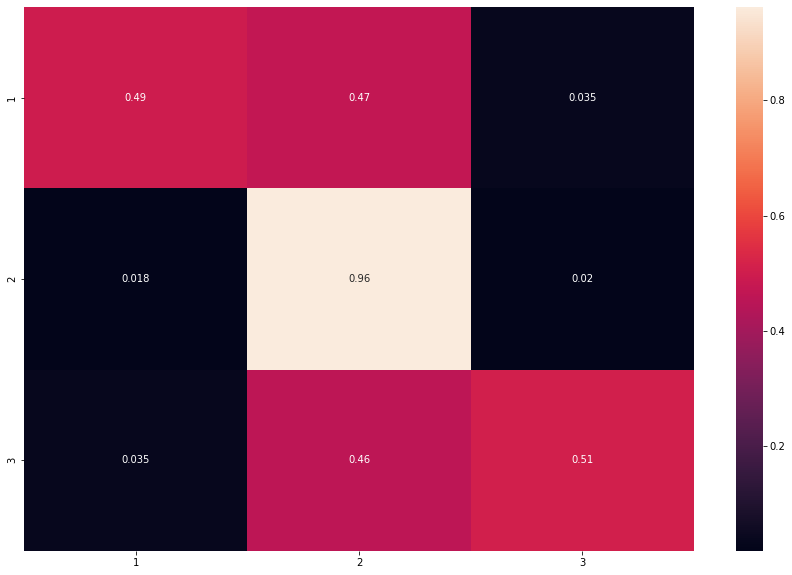

In [9]:
get_heatmap_confusion_matrix(df)

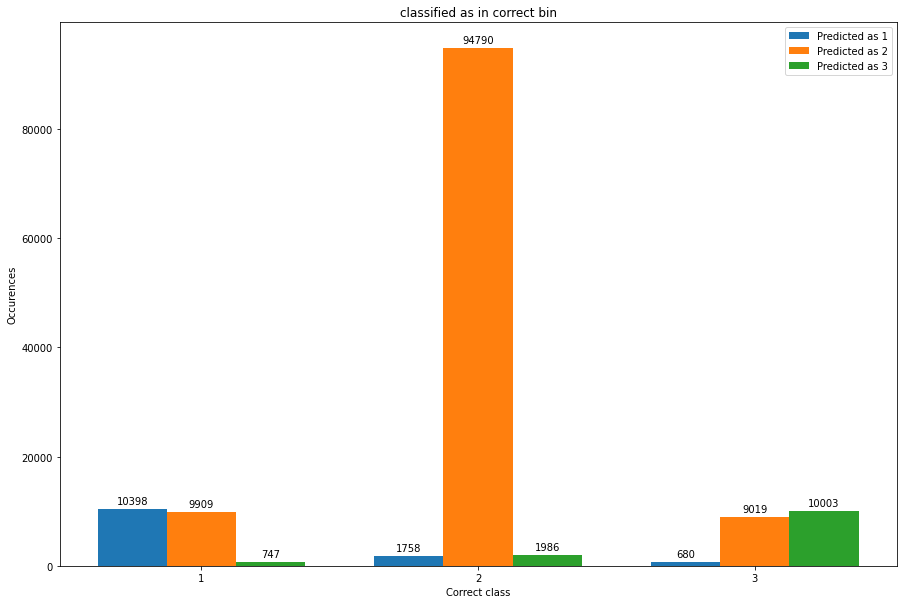

In [10]:
plot_groups(df)

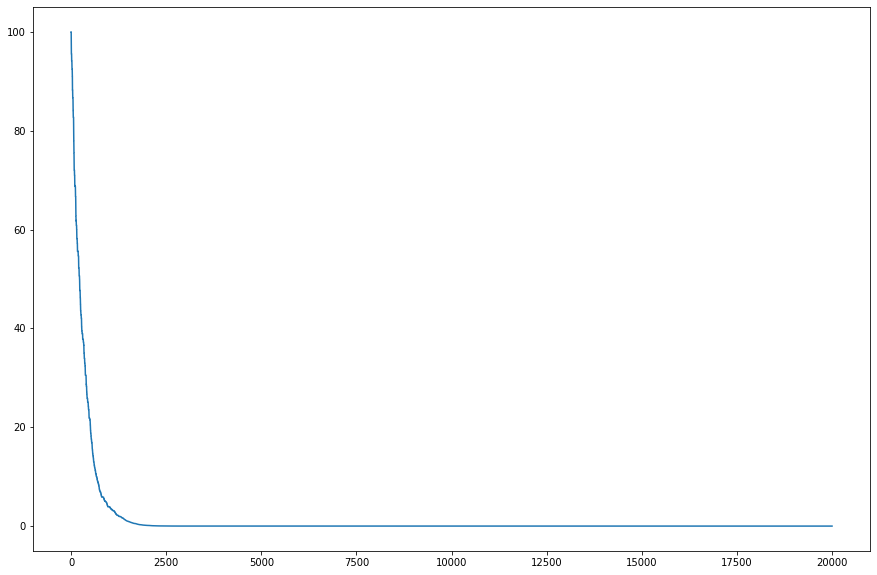

In [17]:
#Construction of game. 
#The game uses the dataframe df which has two columns ["real", "predicted"]. The game matches these columns and rewards 
#to the fortune when correct and subtracts when incorrect.
current_fortune = []
possible_positions = []
#initial variables 
initial_stake = 100
brokerage = 0.0004 
#^jf finnish pricing as "active trader package ": https://www.nordnet.dk/dk/kundeservice/prisliste/priser-aktiedepot 
correct_return = 0.002 + random.uniform(-0.2, 0.2) #0.2% return when model is correct  #coeffecient is a shot in the dark, and
wrong_return = -0.001 + random.uniform(-0.2, 0.2) #-0.2% loss when model is incorrect #coeffecient is a shot in the dark
uniform_parameter = 0.002 #Random retrun when prediction is 1 or 3 but y_test is 2 #coeffecient is a shot in the dark

def update_initail_stake(price_after_purchase_brokage, return_type, brokerage):
    saleable_price = price_after_purchase_brokage*(1+return_type)
    return saleable_price*(1 - 1*brokerage)

for index, row in df.head(20000).iterrows():
    possible_positions.append(index)
    current_fortune.append(initial_stake)
    price_after_purchase_brokage = initial_stake*(1-brokerage)
    if (row["real"] == 1 and row["predicted"] == 1):
        initial_stake = update_initail_stake(price_after_purchase_brokage, correct_return, brokerage)
    elif (row["real"] == 1 and row["predicted"] == 3):
        initail_stake = update_initail_stake(price_after_purchase_brokage, wrong_return, brokerage)
    elif (row["real"] == 2 and row["predicted"] == 1):
        initial_stake = update_initail_stake(price_after_purchase_brokage, random.uniform(-uniform_parameter, uniform_parameter), brokerage)
    elif (row["real"] == 2 and row["predicted"] == 3):
        initial_stake = update_initail_stake(price_after_purchase_brokage, random.uniform(-uniform_parameter, uniform_parameter), brokerage)
    elif (row["real"] == 3 and row["predicted"] == 1):
        initail_stake = update_initail_stake(price_after_purchase_brokage, wrong_return, brokerage)
    elif (row["real"] == 3 and row["predicted"] == 3):
        initial_stake = update_initail_stake(price_after_purchase_brokage, correct_return, brokerage)

plt.plot(possible_positions,current_fortune)
plt.show()

#Cloud setup of models (ceid)
#Look at trading simulators. (Backtrader)
#Try with different input data(Not from testset, just general market data, e.g S&P500)
#Submit before christmas holidays. 
#Look into dataaugmentation (https://arxiv.org/abs/2011.04545)